In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import gc
import time
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb
import xgbfir

from tqdm import tqdm_notebook

pd.set_option('max_columns', None)

SEED = 2131
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

%run ../src/data/HotstarDataset.py
%run ../src/features/categorical_features.py
%run ../src/features/util.py
%run ../src/models/cross_validation.py

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading Data

In [2]:
def reload_data():
    dataset = Hotstar('../data/raw/5f828822-4--4-hotstar_dataset/')
    dataset.load_data('../data/processed/hotstar_processed.feather')
    
    data_processed = dataset.data
    train_mask     = dataset.get_train_mask()
    
    return data_processed, train_mask

## Data Preparation

In [3]:
def summation(viewership):
    viewership = np.array(viewership)
    viewership  = viewership.astype(np.int)
    
    return viewership.sum()
    

def data_preparation(data_processed, **params):
    """
    Function to prepare dataset for modelling
    """
    
    st = time.time() # start time
    
    # viewership
    viewership     = data_processed.cities.str.replace(r'[^\d|^,]+', '').str.split(',').map(summation)
    data_processed = data_processed.assign(viewership=viewership)
    
    print('Prepared viewership')
    
    del viewership
    gc.collect()
    
    
    # number of cities involved
    num_cities     = data_processed.cities.str.split(',').map(len)
    data_processed = data_processed.assign(num_cities=num_cities)
    
    print('Prepared num cities')
    del num_cities
    gc.collect()
    
    # num genres watched
    num_genres     = data_processed.genres.str.split(',').map(len)
    data_processed = data_processed.assign(num_genres=num_genres)
    
    print('Prepared num genres')
    del num_genres
    gc.collect()
    
    # num titles watched
    num_titles     = data_processed.titles.str.split(',').map(len)
    data_processed = data_processed.assign(num_titles=num_titles)
    
    print('Prepared num titles')
    del num_titles
    gc.collect()
    
    # num tod
    num_tod        = data_processed.tod.str.split(',').map(len)
    data_processed = data_processed.assign(num_tod=num_tod)
    
    print('Prepared num tod')
    del num_tod
    gc.collect()
    
    # num DOW
    num_dow        = data_processed.dow.str.split(',').map(len)
    data_processed = data_processed.assign(num_dow=num_dow)
    
    print('Prepared num dow')
    del num_dow
    gc.collect()
    
    # dow OHE
    dow_dict_train = data_processed.loc[train_mask, 'dow'].map(lambda x: x.split(','))\
                     .map(lambda x: dict((k.strip(), int(v.strip())) for k,v in 
                                          (item.split(':') for item in x)))

    dow_dict_test  = data_processed.loc[~train_mask, 'dow'].map(lambda x: x.split(','))\
                         .map(lambda x: dict((k.strip(), int(v.strip())) for k,v in 
                                              (item.split(':') for item in x)))

    dv     = DictVectorizer(sparse=False)
    X1     = dv.fit_transform(dow_dict_train)
    Xtest1 = dv.transform(dow_dict_test)
    
    X1 = pd.DataFrame(np.vstack((X1, Xtest1)), columns=['dow' + c for c in dv.get_feature_names()])
    data_processed = pd.concat((data_processed, X1), axis='columns')
    print('Prepared DOW OHE')
    
    # genres OHE
    genres_dict_train = data_processed.loc[train_mask, 'genres'].map(lambda x: x.split(','))\
                     .map(lambda x: dict((k.strip(), int(v.strip())) for k,v in 
                                          (item.split(':') for item in x)))

    genres_dict_test  = data_processed.loc[~train_mask, 'genres'].map(lambda x: x.split(','))\
                         .map(lambda x: dict((k.strip(), int(v.strip())) for k,v in 
                                              (item.split(':') for item in x)))

    dv     = DictVectorizer(sparse=False)
    X1     = dv.fit_transform(genres_dict_train)
    Xtest1 = dv.transform(genres_dict_test)

    X1 = pd.DataFrame(np.vstack((X1, Xtest1)), columns=dv.get_feature_names())
    data_processed = pd.concat((data_processed, X1), axis='columns')
    print('Prepared genres OHE')
    
    # tod OHE
    tod_dict_train = data_processed.loc[train_mask, 'tod'].map(lambda x: x.split(','))\
                     .map(lambda x: dict((k.strip(), int(v.strip())) for k,v in 
                                          (item.split(':') for item in x)))

    tod_dict_test  = data_processed.loc[~train_mask, 'tod'].map(lambda x: x.split(','))\
                         .map(lambda x: dict((k.strip(), int(v.strip())) for k,v in 
                                              (item.split(':') for item in x)))

    dv     = DictVectorizer(sparse=False)
    X1     = dv.fit_transform(tod_dict_train)
    Xtest1 = dv.transform(tod_dict_test)

    X1 = pd.DataFrame(np.vstack((X1, Xtest1)), columns=['tod' + col for col in dv.get_feature_names()])
    data_processed = pd.concat((data_processed, X1), axis='columns')
    
    print('Prepared tod OHE')
    
    # convert watch time for three of the genres to hour.
    data_processed = data_processed.assign(cricket_view_hour=data_processed.Cricket / 3600)
    data_processed = data_processed.assign(romance_view_hour=data_processed.Romance / 3600)
    data_processed = data_processed.assign(ts_view_hour=data_processed.TalkShow / 3600)
    
    # mask for cricket view hour, romance view hour and talk show view hour
    data_processed = data_processed.assign(low_cricket_view=(data_processed.cricket_view_hour < data_processed.cricket_view_hour.quantile(q=.45)).astype('uint8'))
    data_processed = data_processed.assign(high_romance_view=(data_processed.romance_view_hour > data_processed.romance_view_hour.quantile(q=.99)).astype('uint8'))
    data_processed = data_processed.assign(high_ts_view=(data_processed.ts_view_hour > data_processed.ts_view_hour.quantile(q=.99)).astype('uint8'))
    
    if params['transform']:
        # TFIDF transformer
        vec = TfidfTransformer()
        features_to_transform = ['dow1', 'dow2', 'dow3', 'dow4', 'dow5', 'dow6', 'dow7',
           'Action', 'Athletics', 'Awards', 'Badminton', 'Boxing', 'Comedy',
           'Cricket', 'Crime', 'Documentary', 'Drama', 'Family', 'Football',
           'Formula1', 'FormulaE', 'Hockey', 'Horror', 'IndiaVsSa', 'Kabaddi',
           'Kids', 'LiveTV', 'Mythology', 'NA', 'Reality', 'Romance', 'Science',
           'Sport', 'Swimming', 'Table Tennis', 'TalkShow', 'Teen', 'Tennis',
           'Thriller', 'Travel', 'Volleyball', 'Wildlife', 'tod0', 'tod1', 'tod10',
           'tod11', 'tod12', 'tod13', 'tod14', 'tod15', 'tod16', 'tod17', 'tod18',
           'tod19', 'tod2', 'tod20', 'tod21', 'tod22', 'tod23', 'tod3', 'tod4',
           'tod5', 'tod6', 'tod7', 'tod8', 'tod9']

        transformed = vec.fit_transform(data_processed.loc[:, features_to_transform])
        transformed = pd.DataFrame(transformed.toarray(), columns=features_to_transform)

        data_processed.drop(features_to_transform, axis='columns', inplace=True)
        data_processed = pd.concat((data_processed, transformed), axis='columns')

        print('TFIDF transformed')
    
    print('Prepared flags for cricket, romance and talkshow genres')
    
    # feature interaction between features
    data_processed = data_processed.assign(cric_rom=data_processed.cricket_view_hour * data_processed.romance_view_hour)
    data_processed = data_processed.assign(cric_ts=data_processed.cricket_view_hour * data_processed.ts_view_hour)
    data_processed = data_processed.assign(rom_ts=data_processed.romance_view_hour * data_processed.ts_view_hour)
    
    print('Prepared Feature Interaction')
    
    # proportion of cricket watch time out of total viewership
    proportion_cric_wt = (data_processed.Cricket) / (data_processed.viewership)
    data_processed = data_processed.assign(proportion_cric_wt=proportion_cric_wt)
    
    print('Prepared cricket watch time proportion')
    
    # proportion of romance watch time out of total
    prop_romance_wt = (data_processed.Romance) / (data_processed.viewership)
    data_processed  = data_processed.assign(prop_romance_wt=prop_romance_wt)
    
    print('Prepared romance watch time proportion')
    
    # proportion of family watch time out of total
    prop_family_wt = (data_processed.Family) / (data_processed.viewership)
    data_processed  = data_processed.assign(prop_family_wt=prop_family_wt)
    
    print('Prepared family watch time proportion')
    
    # flag for those instances with very high viewership
    data_processed = data_processed.assign(high_viewership=(data_processed.viewership > data_processed.viewership.quantile(q=.99)).astype('uint8'))
    
    print('Prepared high viewership')
    
    et = time.time() # end time
    
    print('It took: {} seconds to prepare data'.format(et - st))
    
    return data_processed

In [4]:
def plot_real_feature(fname):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(data_processed.loc[train_mask][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(data_processed.loc[train_mask & (data_processed.segment == 0)][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not target')    
    sns.distplot(data_processed.loc[train_mask & (data_processed.segment == 1)][fname], 
                 bins=50, 
                 ax=ax2,
                 label='target')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='segment', 
                data=data_processed.loc[train_mask], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='segment', 
                   data=data_processed.loc[train_mask], 
                   ax=ax4)
    plt.show()

In [5]:
def plot_corr(predictors):
    plt.figure(figsize=(10, 10))
    predictors = predictors[:]
    predictors += ['segment']
    mcorr = data_processed.loc[train_mask][predictors].corr()
    mask = np.zeros_like(mcorr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')
    g.set_xticklabels(predictors, rotation=90)
    g.set_yticklabels(reversed(predictors))
    plt.show()

```
Feature Generation Ideas

Feature Intearction report generated by the XGBFI clearly states out Cricket genre as the one
with the most predictive power. How can we use this feature to generate more meaniningul features ?
```

## Data Preparation

In [6]:
data_processed, train_mask = reload_data()

params = {
    'transform': False
}

data_processed = data_preparation(data_processed, **params)

Prepared viewership
Prepared num cities
Prepared num genres
Prepared num titles
Prepared num tod
Prepared num dow
Prepared DOW OHE
Prepared genres OHE
Prepared tod OHE
Prepared flags for cricket, romance and talkshow genres
Prepared Feature Interaction
Prepared cricket watch time proportion
Prepared romance watch time proportion
Prepared family watch time proportion
Prepared high viewership
It took: 23.793744325637817 seconds to prepare data


In [8]:
data_processed.titles.values

array([ "Top Raids: Haryana vs Services SCB:103,Day 4: India Move in for the Kill:20,India vs Australia 2nd Test English:1907,SRH vs RCB:6777,KKR vs KXIP:6386,MI vs SRH:2372,PKL 2015: Most Valuable Defenders of Season 2:2,Yuvraj's Blazing 62 off 27 vs RCB:12,Day 1: India Stun Oz with Pace:16,Dance +:4618,17 May: Virat's Chat With Anushka That Landed Him in Trouble:121,2013: India Chase Down 362 vs Aus:635,Virat Kohli's 4th 100 of VIVO IPL 2016:297,Day 2: Spinners Turn Tables on India:1024,Team Profile: MI:114,Top Tackles: Services SCB vs Maharashtra:4,Turbanator Bhajji turns it on in IPL final:66,Team Profile: RCB:20,MI beat RCB Despite Badree Hat-trick:6,CSK's journey to the IPL final:99,Stokes Mills Lead List of Big Buys:4,India vs England 1st T20I English:5453,KKR vs SRH:1872,Ruthless India Stay Perfect at Home:508,Team Profile: KXIP:129,RCB vs DD:1576,Nach Baliye 7:132,DD vs KXIP:3758,Day 3: India Finally Break Oz Spirit:1415,10 Years of VIVO IPL: Then and Now:32,Top Tackles: Bulls

In [97]:
def get_unique_cities(df):
    cities = set([])
    df.cities.str.replace(':\d+', '').map(lambda x: [cities.add(city) for city in x.split(',')])
    return cities

def get_titles(df):
    titles = set([])
    df.titles.str.split(r':\d+').map(lambda x: [titles.add(re.sub(r'[,"\' ]', '', title)) for title in x if len(title) > 0])
    return titles

def prepare_titles(df):
    def cleanup(titles):
        cleaned_titles = []
        
        for title in titles:
            cleaned_titles.append(re.sub(r'[,"\']', '', title))
            
        return ' '.join(cleaned_titles)
    
    return df.titles.str.split(r':\d+').map(cleanup)

In [78]:
train_titles = get_titles(data_processed.loc[train_mask])
test_titles  = get_titles(data_processed.loc[~train_mask])

In [82]:
test_titles

{'World Record: The Fastest Smash Ever ',
 'Cochin Express',
 'The Other Man',
 'Hero ISL NorthEast United FC vs Mumbai City FC: John Abraham interview',
 'Pepsi IPL 2015: Qualifier2 CSK vs RCB: Wicket! Sarfaraz Khans brilliant throw runs Pawan Negi out',
 'IPL hangover? McCullum smashes a first-ball six!',
 'Daagdi Chawl',
 'Rayudus Fighting 54 Rescues MI',
 'SARAVANAN MEENATCHI',
 'Watch Gambhirs Juggling Skills',
 'PV Sindhu defends Macau Grand Prix title',
 'Kohli Races to 191* on Day 2',
 'Turbanator turns it on!',
 'NAVYA - Naye Dhadkan Naye Sawaal',
 'Dance   Get Set Go',
 'Mukunthetta Sumitra Vilikkunnu',
 'Ishants Game Face Challenge ',
 'Quarterfinals: Top Shots',
 'DD vs MI: All Wickets ft_ Amit Mishra',
 'Lynns 84* Wins it for Heat ',
 'Vignesh Restricts Dragons With 3-for',
 'Karun Nairs awesome flick shot!',
 '64! Uthappa Ups the Ante For KKR',
 'Mills Wins the Lottery with RCB',
 'Hoffenheim vs Bayern Munich',
 'Sambandada Siri',
 'Virats 49 Flattens Rivals Pakistan',
 '

In [86]:
len(train_titles & test_titles)

10485

In [80]:
len(train_titles - test_titles)

2808

In [81]:
len(test_titles - train_titles)

1293

In [55]:
data_processed.iloc[:1].titles.str.split(r':\d+').values[0]

['Top Raids: Haryana vs Services SCB',
 ',Day 4: India Move in for the Kill',
 ',India vs Australia 2nd Test English',
 ',SRH vs RCB',
 ',KKR vs KXIP',
 ',MI vs SRH',
 ',PKL 2015: Most Valuable Defenders of Season 2',
 ",Yuvraj's Blazing 62 off 27 vs RCB",
 ',Day 1: India Stun Oz with Pace',
 ',Dance +',
 ",17 May: Virat's Chat With Anushka That Landed Him in Trouble",
 ',2013: India Chase Down 362 vs Aus',
 ",Virat Kohli's 4th 100 of VIVO IPL 2016",
 ',Day 2: Spinners Turn Tables on India',
 ',Team Profile: MI',
 ',Top Tackles: Services SCB vs Maharashtra',
 ',Turbanator Bhajji turns it on in IPL final',
 ',Team Profile: RCB',
 ',MI beat RCB Despite Badree Hat-trick',
 ",CSK's journey to the IPL final",
 ',Stokes Mills Lead List of Big Buys',
 ',India vs England 1st T20I English',
 ',KKR vs SRH',
 ',Ruthless India Stay Perfect at Home',
 ',Team Profile: KXIP',
 ',RCB vs DD',
 ',Nach Baliye 7',
 ',DD vs KXIP',
 ',Day 3: India Finally Break Oz Spirit',
 ',10 Years of VIVO IPL: Then and 

In [52]:
re.findall(r':\d+', ss)

[':103',
 ':20',
 ':1907',
 ':6777',
 ':6386',
 ':2372',
 ':2',
 ':12',
 ':16',
 ':4618',
 ':121',
 ':635',
 ':297',
 ':1024',
 ':114',
 ':4',
 ':66',
 ':20',
 ':6',
 ':99',
 ':4',
 ':5453',
 ':1872',
 ':508',
 ':129',
 ':1576',
 ':132',
 ':3758',
 ':1415',
 ':32',
 ':145',
 ':4029',
 ':596',
 ':281',
 ':5',
 ':7788',
 ':101',
 ':4',
 ':173',
 ':0',
 ':237',
 ':3364',
 ':138',
 ':208',
 ':285',
 ':115',
 ':3514',
 ':142',
 ':9186',
 ':18',
 ':56',
 ':26',
 ':65',
 ':26',
 ':2558',
 ':1111',
 ':2',
 ':7256',
 ':4610',
 ':1846']

In [24]:
data_processed.iloc[:10].titles.str.split(r':').values[0]

['Top Raids',
 ' Haryana vs Services SCB',
 '103,Day 4',
 ' India Move in for the Kill',
 '20,India vs Australia 2nd Test English',
 '1907,SRH vs RCB',
 '6777,KKR vs KXIP',
 '6386,MI vs SRH',
 '2372,PKL 2015',
 ' Most Valuable Defenders of Season 2',
 "2,Yuvraj's Blazing 62 off 27 vs RCB",
 '12,Day 1',
 ' India Stun Oz with Pace',
 '16,Dance +',
 '4618,17 May',
 " Virat's Chat With Anushka That Landed Him in Trouble",
 '121,2013',
 ' India Chase Down 362 vs Aus',
 "635,Virat Kohli's 4th 100 of VIVO IPL 2016",
 '297,Day 2',
 ' Spinners Turn Tables on India',
 '1024,Team Profile',
 ' MI',
 '114,Top Tackles',
 ' Services SCB vs Maharashtra',
 '4,Turbanator Bhajji turns it on in IPL final',
 '66,Team Profile',
 ' RCB',
 '20,MI beat RCB Despite Badree Hat-trick',
 "6,CSK's journey to the IPL final",
 '99,Stokes Mills Lead List of Big Buys',
 '4,India vs England 1st T20I English',
 '5453,KKR vs SRH',
 '1872,Ruthless India Stay Perfect at Home',
 '508,Team Profile',
 ' KXIP',
 '129,RCB vs DD'

In [14]:
train_cities = get_unique_cities(data_processed.loc[train_mask, :])

In [16]:
test_cities = get_unique_cities(data_processed.loc[~train_mask, :])

In [21]:
len(train_cities)

1358

In [19]:
len(test_cities - train_cities)

277

In [20]:
len(train_cities - test_cities)

635

### Cross-validation

In [176]:
def cross_validate_single_model_sign(X, y, model, ret_fold_preds=False,
                   save_folds=False, plot_cv_scores=False):
    """
    Stratified K-Fold with 10 splits and then save each fold
    and analyze the performance of the model on each fold
    """
    
    skf = StratifiedKFold(n_splits=10, random_state=SEED)
    fold_counter = 0
    
    cv_scores = []
    preds     = []
    
    for (itr, ite) in tqdm_notebook(skf.split(X, y)):
        Xtr = X.iloc[itr]
        ytr = y.iloc[itr]
        
        Xte = X.iloc[ite]
        yte = y.iloc[ite]
        
        if save_folds:
            save_file(pd.concat((Xtr, ytr), axis='columns'), '../data/processed/train_fold%s.feather'%(fold_counter))
            save_file(pd.concat((Xte, yte), axis='columns'), '../data/processed/test_fold%s.feather'%(fold_counter))
        
        print('Training model')
        start_time = time.time()
        model.fit(Xtr, ytr)
        end_time   = time.time()
        
        print('Took: {} seconds to train model'.format(end_time - start_time))
        
        start_time  = time.time()
        fold_preds  = model.predict_proba(Xte)[:, 1]
        end_time    = time.time()
        
        if ret_fold_preds:
            preds.append(fold_preds)
        
        print('Took: {} seconds to generate predictions'.format(end_time - start_time))
        
        fold_score = roc_auc_score(yte, fold_preds)
        print('Fold log loss score: {}'.format(fold_score))
        
        cv_scores.append(fold_score)
        print('='*75)
        print('\n')
        
    if plot_cv_scores:
        plt.scatter(np.arange(0, len(cv_scores)), cv_scores)
    
    print('Mean cv score: {} \n Std cv score: {}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    return preds

** Filter out features **

In [237]:
data_processed.columns

Index(['ID', 'cities', 'dow', 'genres', 'segment', 'titles', 'tod',
       'viewership', 'num_cities', 'num_genres', 'num_titles', 'num_tod',
       'num_dow', 'cricket_view_hour', 'romance_view_hour', 'ts_view_hour',
       'low_cricket_view', 'high_romance_view', 'high_ts_view', 'dow1', 'dow2',
       'dow3', 'dow4', 'dow5', 'dow6', 'dow7', 'Action', 'Athletics', 'Awards',
       'Badminton', 'Boxing', 'Comedy', 'Cricket', 'Crime', 'Documentary',
       'Drama', 'Family', 'Football', 'Formula1', 'FormulaE', 'Hockey',
       'Horror', 'IndiaVsSa', 'Kabaddi', 'Kids', 'LiveTV', 'Mythology', 'NA',
       'Reality', 'Romance', 'Science', 'Sport', 'Swimming', 'Table Tennis',
       'TalkShow', 'Teen', 'Tennis', 'Thriller', 'Travel', 'Volleyball',
       'Wildlife', 'tod0', 'tod1', 'tod10', 'tod11', 'tod12', 'tod13', 'tod14',
       'tod15', 'tod16', 'tod17', 'tod18', 'tod19', 'tod2', 'tod20', 'tod21',
       'tod22', 'tod23', 'tod3', 'tod4', 'tod5', 'tod6', 'tod7', 'tod8',
       'tod9', '

In [239]:
features = [
           'viewership', 'num_cities', 'num_genres', 'num_titles', 'num_tod',
           'num_dow', 'dow1', 'dow2', 'dow3', 'dow4', 'dow5', 'dow6', 'dow7',
           'Action', 'Athletics', 'Awards', 'Badminton', 'Boxing', 'Comedy',
           'Cricket', 'Crime', 'Documentary', 'Drama', 'Family', 'Football',
           'Formula1', 'FormulaE', 'Hockey', 'Horror', 'IndiaVsSa', 'Kabaddi',
           'Kids', 'LiveTV', 'Mythology', 'NA', 'Reality', 'Romance', 'Science',
           'Sport', 'Swimming', 'Table Tennis', 'TalkShow', 'Teen', 'Tennis',
           'Thriller', 'Travel', 'Volleyball', 'Wildlife', 'tod0', 'tod1', 'tod10',
           'tod11', 'tod12', 'tod13', 'tod14', 'tod15', 'tod16', 'tod17', 'tod18',
           'tod19', 'tod2', 'tod20', 'tod21', 'tod22', 'tod23', 'tod3', 'tod4',
           'tod5', 'tod6', 'tod7', 'tod8', 'tod9', 'low_cricket_view',
           'high_romance_view', 'high_ts_view', 'cric_rom', 'cric_ts', 'rom_ts',
           'proportion_cric_wt', 'prop_romance_wt', 'prop_family_wt',
           'high_viewership'
           ]

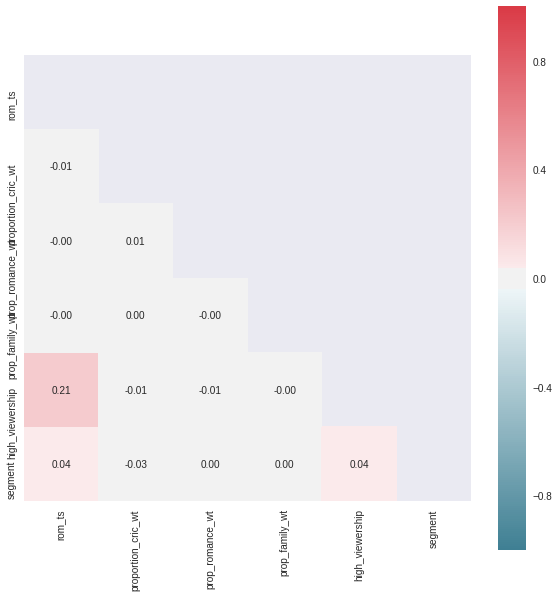

In [240]:
plot_corr(features[-5:])

In [241]:
X = data_processed.loc[train_mask, features]
y = data_processed.loc[train_mask, 'segment']

Xtest = data_processed.loc[~train_mask, features]

In [242]:
params = {
    'stratify': y,
    'test_size': .2,
    'random_state': SEED
}

X_train, X_test, y_train, y_test = get_train_test_split(X, y, **params)

** Manual Tuning **

In [247]:
dtrain = xgb.DMatrix(X_train, y_train, missing=np.nan)
dval   = xgb.DMatrix(X_test, y_test, missing=np.nan)

xgb_params = {
    'eta': 0.08,
    'max_depth': 2,
    'gamma': 1,
    'colsample_bytree': .8,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': SEED,
    'silent': 1
}

n_estimators = 500

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round=n_estimators, verbose_eval=10,
                  evals=watchlist
                 )

[0]	train-auc:0.760799	val-auc:0.751552
[10]	train-auc:0.782222	val-auc:0.773551
[20]	train-auc:0.787233	val-auc:0.77943
[30]	train-auc:0.791258	val-auc:0.783087
[40]	train-auc:0.796597	val-auc:0.789171
[50]	train-auc:0.801219	val-auc:0.794193
[60]	train-auc:0.804388	val-auc:0.797284
[70]	train-auc:0.806571	val-auc:0.799272
[80]	train-auc:0.808402	val-auc:0.800931
[90]	train-auc:0.809808	val-auc:0.801958
[100]	train-auc:0.8109	val-auc:0.802883
[110]	train-auc:0.81183	val-auc:0.803549
[120]	train-auc:0.812657	val-auc:0.804149
[130]	train-auc:0.813367	val-auc:0.804658
[140]	train-auc:0.814013	val-auc:0.804959
[150]	train-auc:0.814621	val-auc:0.80536
[160]	train-auc:0.815092	val-auc:0.805596
[170]	train-auc:0.81553	val-auc:0.805907
[180]	train-auc:0.815981	val-auc:0.806113
[190]	train-auc:0.816433	val-auc:0.80635
[200]	train-auc:0.816815	val-auc:0.80652
[210]	train-auc:0.817201	val-auc:0.806675
[220]	train-auc:0.817567	val-auc:0.80673
[230]	train-auc:0.817927	val-auc:0.806783
[240]	train-

In [250]:
# model = RandomForestClassifier(n_estimators=300, max_depth=10, max_features='sqrt', random_state=SEED, n_jobs=-1)
# model = ExtraTreesClassifier(n_estimators=300, max_depth=15, random_state=SEED, n_jobs=-1)
model = xgb.XGBClassifier(n_estimators=300, max_depth=4, colsample_bytree=.7, seed=SEED)
# model = LogisticRegression(random_state=SEED)

In [251]:
params = {
    'ret_fold_preds': True,
    'save_folds': False,
    'plot_cv_scores': False
}

cv_scores = cross_validate_single_model_sign(X_train, y_train, model, **params)

Training model


KeyboardInterrupt: 

** Performance on holdout set **

In [81]:
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]
print('ROC AUC score: {}'.format(roc_auc_score(y_test, preds)))

ROC AUC score: 0.8090944342844535


** Full training **

In [82]:
st = time.time()
xgb_model = model.fit(X, y)
et = time.time()

preds = model.predict_proba(Xtest)[:, 1]
print('Took: {} seconds to train model'.format(et - st))

# saving to file with proper feature names
xgbfir.saveXgbFI(xgb_model, featu re_names=X.columns, OutputXlsxFile = '../data/interim/FI.xlsx')

Took: 36.290414571762085 seconds to train model


In [231]:
sub = pd.read_csv('../data/raw/5f828822-4--4-hotstar_dataset/sample_submission.csv')

In [233]:
sub            = pd.read_csv('../data/raw/5f828822-4--4-hotstar_dataset/sample_submission.csv')
sub['segment'] = preds
sub['ID']      = data_processed.loc[~train_mask, 'ID'].values
sub.to_csv('../submissions/hotstar/xgb_experiment_16.csv', index=False)